# Example 10: Full workflow

This example contains the full workflow
1. Request data from IRIS to make an MTH5
2. Compute a transfer function using Aurora
3. Adding the transfer function to MHT5
4. Visualize using MTpy

**Note:** this example assumes that data availability (Network, Station, Channel, Start, End) are all previously known.  If you do not know the data that you want to download use [IRIS tools](https://ds.iris.edu/ds/nodes/dmc/tools/##) to get data availability.   

## 1. Create MTH5 from IRIS

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from mth5.mth5 import MTH5
from mth5.clients.make_mth5 import MakeMTH5

from matplotlib import pyplot as plt
%matplotlib inline

2022-10-19 19:18:17,370 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


### Set the path to save files to as the current working directory

In [3]:
default_path = Path().cwd()
print(default_path)

C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\notebooks\mth5


### Initialize a MakeMTH5 object

Here, we are setting the MTH5 file version to 0.2.0 so that we can have multiple surveys in a single file.  Also, setting the client to "IRIS".  Here, we are using `obspy.clients` tools for the request.  Here are the available [FDSN clients](https://docs.obspy.org/packages/obspy.clients.fdsn.html). 

**Note:** Only the "IRIS" client has been tested.

In [7]:
make_mth5_object = MakeMTH5(mth5_version='0.2.0')
make_mth5_object.client = "IRIS"

### Make the data inquiry as a DataFrame

There are a few ways to make the inquiry to request data.  

1. Make a DataFrame by hand.  Here we will make a list of entries and then create a DataFrame with the proper column names
2. You can create a CSV file with a row for each entry. There are some formatting that you need to be aware of.  That is the column names and making sure that date-times are YYYY-MM-DDThh:mm:ss


| Column Name         |   Description                                                                                                 |
| ------------------- | --------------------------------------------------------------------------------------------------------------|
| **network**         | [FDSN Network code (2 letters)](http://www.fdsn.org/networks/)                                                |
| **station**         | [FDSN Station code (usually 5 characters)](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/)|
| **location**        | [FDSN Location code (typically not used for MT)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/location-codes.html) |
| **channel**         | [FDSN Channel code (3 characters)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/channel-codes.html)|
| **start**           | Start time (YYYY-MM-DDThh:mm:ss) UTC |
| **end**             | End time (YYYY-MM-DDThh:mm:ss) UTC  |

To create the request you can use any of the [IRIS Data Services tools](https://ds.iris.edu/ds/nodes/dmc/tools/##), a nice map view request [GMAP](http://ds.iris.edu/gmap/).  Be sure to identify 2 stations that recorded at the same time for at least a week.  Network codes for MT that have correct metadata are `ZU` and `8P`, other network codes like `EM` still need work on making sure calibrations are correct.


In [13]:
channels = ["LFE", "LFN", "LFZ", "LQE", "LQN"]
 
WYYS2 = ["EM", "WYYS2", "2009-07-15T00:00:00", "2009-08-21T00:00:00"]
MTF20 = ["EM", "MTF20", "2009-07-03T00:00:00", "2009-08-13T00:00:00"]

request_list = []
for entry in [WYYS2, MTF20]:
    for channel in channels:
        request_list.append(
            [entry[0], entry[1], "", channel, entry[2], entry[3]]
        )

# Turn list into dataframe
request_df =  pd.DataFrame(request_list, columns=make_mth5_object.column_names) 
request_df.to_csv(default_path.joinpath("fdsn_request.csv"))
request_df

,network,station,location,channel,start,end
0,EM,WYYS2,,LFE,2009-07-15T00:00:00,2009-08-21T00:00:00
1,EM,WYYS2,,LFN,2009-07-15T00:00:00,2009-08-21T00:00:00
2,EM,WYYS2,,LFZ,2009-07-15T00:00:00,2009-08-21T00:00:00
3,EM,WYYS2,,LQE,2009-07-15T00:00:00,2009-08-21T00:00:00
4,EM,WYYS2,,LQN,2009-07-15T00:00:00,2009-08-21T00:00:00
5,EM,MTF20,,LFE,2009-07-03T00:00:00,2009-08-13T00:00:00
6,EM,MTF20,,LFN,2009-07-03T00:00:00,2009-08-13T00:00:00
7,EM,MTF20,,LFZ,2009-07-03T00:00:00,2009-08-13T00:00:00
8,EM,MTF20,,LQE,2009-07-03T00:00:00,2009-08-13T00:00:00
9,EM,MTF20,,LQN,2009-07-03T00:00:00,2009-08-13T00:00:00


### Get only the metadata from IRIS

It can be helpful to make sure that your request is what you would expect.  For that you can request only the metadata from IRIS.  The request is quick and light so shouldn't need to worry about the speed.  This returns a StationXML file and is loaded into an `obspy.Inventory` object.

In [14]:
inventory, data = make_mth5_object.get_inventory_from_df(request_df, data=False)
inventory.write(default_path.joinpath("example_processing.xml").as_posix(), format="stationxml")
print(inventory)

Inventory created at 2022-10-20T02:31:42.910975Z
	Created by: ObsPy 1.3.0
		    https://www.obspy.org
	Sending institution: MTH5
	Contains:
		Networks (2):
			EM (2x)
		Stations (2):
			EM.MTF20 (Billings, MT, USA)
			EM.WYYS2 (Grant Village, WY, USA)
		Channels (10):
			EM.MTF20..LFZ, EM.MTF20..LFN, EM.MTF20..LFE, EM.MTF20..LQN, 
			EM.MTF20..LQE, EM.WYYS2..LFZ, EM.WYYS2..LFN, EM.WYYS2..LFE, 
			EM.WYYS2..LQN, EM.WYYS2..LQE


### Make an MTH5

Now that we've created a request, and made sure that its what we expect, we can make an MTH5 file.  The input can be either the DataFrame or the CSV file.  We are going to time it just to get an indication how long it might take.  Should take about 4 minutes.

**Note:** we are setting `interact=False`.  If you want to just to keep the file open to interogat it set `interact=True`. 

In [15]:
%%time

mth5_object = make_mth5_object.make_mth5_from_fdsnclient(request_df, interact=False)

print(f"Created {mth5_object}")

2022-10-19 19:32:20,762 [line 672] mth5.mth5.MTH5._initialize_file - INFO: Initialized MTH5 0.2.0 file C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\notebooks\mth5\EM_WYYS2_MTF20.h5 in mode w
2022-10-19 19:35:01,570 [line 498] mt_metadata.timeseries.stationxml.utils.XMLChannelMTChannel._xml_response_to_mt - INFO: Found an unnamed filter, named it: 'zpk_00'


2022-10-19T19:35:01 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage None to a CoefficientFilter


2022-10-19 19:35:01,687 [line 498] mt_metadata.timeseries.stationxml.utils.XMLChannelMTChannel._xml_response_to_mt - INFO: Found an unnamed filter, named it: 'coefficient_00'
2022-10-19 19:35:01,705 [line 498] mt_metadata.timeseries.stationxml.utils.XMLChannelMTChannel._xml_response_to_mt - INFO: Found an unnamed filter, named it: 'zpk_01'


2022-10-19T19:35:01 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage None to a CoefficientFilter


2022-10-19 19:35:01,783 [line 498] mt_metadata.timeseries.stationxml.utils.XMLChannelMTChannel._xml_response_to_mt - INFO: Found an unnamed filter, named it: 'zpk_00'


2022-10-19T19:35:01 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage None to a CoefficientFilter


2022-10-19 19:35:01,860 [line 498] mt_metadata.timeseries.stationxml.utils.XMLChannelMTChannel._xml_response_to_mt - INFO: Found an unnamed filter, named it: 'coefficient_00'
2022-10-19 19:35:01,880 [line 498] mt_metadata.timeseries.stationxml.utils.XMLChannelMTChannel._xml_response_to_mt - INFO: Found an unnamed filter, named it: 'zpk_01'


2022-10-19T19:35:01 [line 134] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage None to a CoefficientFilter


2022-10-19 19:35:02,477 [line 285] mth5.groups.base.MasterSurvey.add_survey - INFO: survey Kansas_2017_Long_Period already exists, returning existing group.
2022-10-19 19:35:02,597 [line 271] mt_metadata.base.metadata.survey.get_station - WARNING: Could not find station WYYS2
2022-10-19 19:35:03,059 [line 794] mth5.groups.base.Station.add_run - INFO: run 001 already exists, returning existing group.
2022-10-19 19:35:03,404 [line 292] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2009-07-15T23:30:42+00:00 does not match metadata end 2009-08-20T00:17:06+00:00 updating metatdata value to 2009-07-15T23:30:42+00:00
2022-10-19 19:35:07,940 [line 278] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: start time of dataset 2009-07-15T23:39:07+00:00 does not match metadata start 2009-07-15T22:43:28+00:00 updating metatdata value to 2009-07-15T23:39:07+00:00
2022-10-19 19:35:07,946 [line 292] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end ti

Created C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\notebooks\mth5\EM_WYYS2_MTF20.h5
Wall time: 3min 18s


In [18]:
mth5_path = mth5_object

## 2. Estimate Transfer Function

Now that an MTH5 has been created we can estimate a transfer function using Aurora.  

In [20]:
import warnings

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.run_summary import RunSummary
from aurora.transfer_function.kernel_dataset import KernelDataset
from aurora.pipelines.process_mth5 import process_mth5

warnings.filterwarnings('ignore')

### Get a Run Summary
Get a run summary from the create mth5. We are going to provide the path to `RunSummary`.     

In [22]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
mth5_run_summary.mini_summary

2022-10-19 19:43:40,195 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\notebooks\mth5\EM_WYYS2_MTF20.h5


,survey,station_id,run_id,start,end
0,Kansas 2017 Long Period,MTF20,001,2009-07-03 22:38:13+00:00,2009-07-04 00:43:53+00:00
1,Kansas 2017 Long Period,MTF20,002,2009-07-04 00:48:01+00:00,2009-07-31 19:39:02+00:00
2,Kansas 2017 Long Period,MTF20,003,2009-07-31 20:47:27+00:00,2009-08-13 00:00:01+00:00
3,Kansas 2017 Long Period,WYYS2,001,2009-07-15 22:43:28+00:00,2009-07-15 23:30:42+00:00
4,Kansas 2017 Long Period,WYYS2,002,2009-07-15 23:39:07+00:00,2009-08-05 19:09:40+00:00
5,Kansas 2017 Long Period,WYYS2,003,2009-08-05 19:49:51+00:00,2009-08-20 00:17:07+00:00


### Define a Kernel Dataset

Make a `KernelDataset` to feed into Aurora.  Here we are going to only use runs longer than 5000 seconds (80 minutes) to be sure we get good estimates at long periods.

**Here you need to change the local station that you are going to process and the remote reference.**

In [25]:
kernel_dataset = KernelDataset()
### kernel_dataset.from_run_summary(run_summary, "local_station", "remote_station")
kernel_dataset.from_run_summary(mth5_run_summary, "WYYS2", "MTF20")
kernel_dataset.drop_runs_shorter_than(5000)
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end
0,Kansas 2017 Long Period,WYYS2,002,2009-07-15 23:39:07+00:00,2009-07-31 19:39:02+00:00
1,Kansas 2017 Long Period,MTF20,002,2009-07-15 23:39:07+00:00,2009-07-31 19:39:02+00:00
2,Kansas 2017 Long Period,WYYS2,002,2009-07-31 20:47:27+00:00,2009-08-05 19:09:40+00:00
3,Kansas 2017 Long Period,MTF20,003,2009-07-31 20:47:27+00:00,2009-08-05 19:09:40+00:00
4,Kansas 2017 Long Period,WYYS2,003,2009-08-05 19:49:51+00:00,2009-08-13 00:00:01+00:00
5,Kansas 2017 Long Period,MTF20,003,2009-08-05 19:49:51+00:00,2009-08-13 00:00:01+00:00


### Now define the processing Configuration

The only things we need to provide are our band processing scheme, and the data sample rate to generate a default processing configuration. The config is then told about the stations via the kernel dataset. Here we are passing it a band file so that we process longer periods.  

**Note:** When doing only single station processing you need to specify RME processing (rather than remote reference processing which expects extra time series from another station)

In [31]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(
    kernel_dataset,
    emtf_band_file=Path("../aurora/bs_256_29.cfg")
)
for decimation in config.decimations:
    decimation.window.type = "hamming"

..\aurora\bs_256_29.cfg
OK


### Call process_mth5

Processing config indicates 4 decimation levels 
OK OK OK
DATASET DF POPULATED
DATASET DF POPULATED
DATASET DF POPULATED
Processing band 25.728968s
Processing band 19.929573s
Processing band 15.164131s
Processing band 11.746086s
Processing band 9.195791s
Processing band 7.362526s
Processing band 5.856115s
Processing band 4.682492s
Processing band 3.784813s
Processing band 3.025193s
Processing band 2.519631s


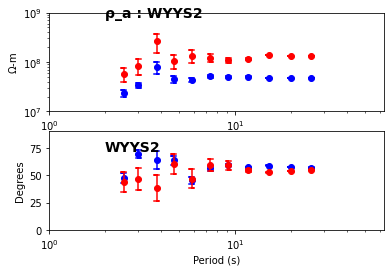

DECIMATION LEVEL 1
RUN OBJECT
/Experiment/Surveys/Kansas_2017_Long_Period/Stations/WYYS2/002:
    --> Dataset: ex
    .................
    --> Dataset: ey
    .................
    --> Dataset: hx
    .................
    --> Dataset: hy
    .................
    --> Dataset: hz
    .................
XRDS
<xarray.Dataset>
Dimensions:  (time: 341999)
Coordinates:
  * time     (time) datetime64[ns] 2009-07-15T23:39:07 ... 2009-07-31T19:38:5...
Data variables:
    ex       (time) float64 -6.646e+06 -6.64e+06 ... 8.927e+04 8.228e+04
    ey       (time) float64 -3.056e+04 -4.988e+04 ... -1.098e+03 -718.1
    hx       (time) float64 1.884e+06 1.884e+06 ... 1.887e+06 1.887e+06
    hy       (time) float64 888.6 891.9 888.4 ... 2.129e+03 2.138e+03 2.139e+03
    hz       (time) float64 5.025e+06 5.025e+06 ... 5.025e+06 5.025e+06
PACKING RUN
HERE is teh dtype of the zero-decimation level run column
ANd the new one
<class 'mth5.groups.master_station_run_channel.RunGroup'>
1.4.3
RUN OBJECT
/Exper

In [ ]:
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=True,
                    z_file_path=None,
                )

### Write Transfer Function to a File

Here we will write to an EMTF XML format

In [34]:
xml_file_base = f"synthetic_test1.xml"
tf_cls.write_tf_file(fn=xml_file_base, file_type="emtfxml")


2022-10-15 14:34:55,738 [line 205] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote synthetic_test1.xml


EMTFXML(station='test1', latitude=0.00, longitude=0.00, elevation=0.00)

## Close MTH5

We have now loaded in all the data we need for long period data.  We can now process these data using **Aurora** and have a look at the transfer functions using **MTpy**.

In [21]:
mth5_object.close_mth5()

2022-10-07 17:56:16,728 [line 325] mth5.mth5.MTH5.filename - WARNING: MTH5 file is not open or has not been created yet. Returning default name
2022-10-07 17:56:16,732 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing EM_WYYS2_MTF20_WYYS3_MTC20.h5
2022-10-07 17:56:16,904 [line 124] mth5.helpers.close_open_files - INFO: Object <class 'h5py._hl.files.File'> does not have __class__
